https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

I'll attempt to implement everything myself to get a better idea of how to do raptor, in case there's any edge cases i miss. Will reuse the docs they provide though.

Questions have different levels of abstractions. Hence, your documents can be fed in an LLM reccursive to build summarizations (which are higher level abstractions) a certain number of times. These LLM generated abstractions can then be saved as docs back into your vectorstore.

Document loading part has many broken links, update to use other pages

<function matplotlib.pyplot.show(close=None, block=None)>

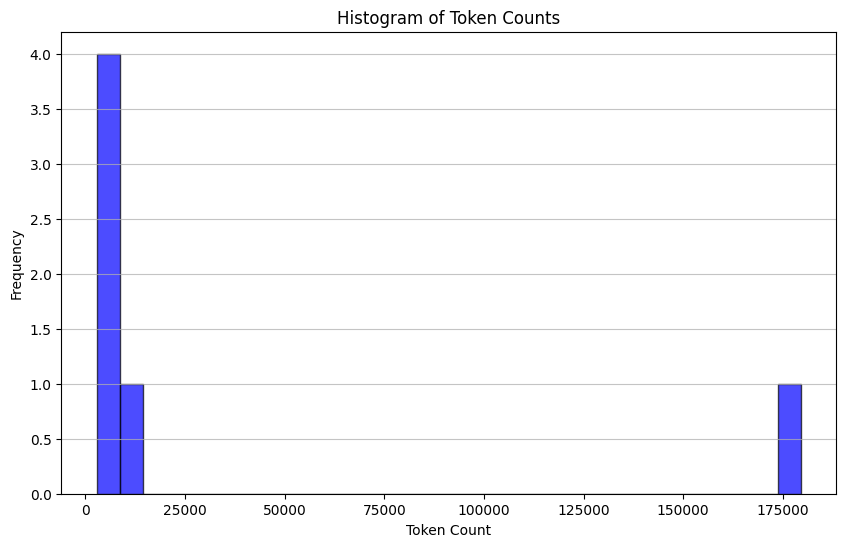

In [1]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/output_parser_structured/"
loader = RecursiveUrlLoader(
    url=url, max_depth=3, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=3, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# 
url = "https://en.wikipedia.org/wiki/Attention_(machine_learning)"
loader = RecursiveUrlLoader(
    url=url, max_depth=3, extractor=lambda x: Soup(x, "html.parser").text
)
docs_attention = loader.load()

url = "https://en.wikipedia.org/wiki/OpenAI_o1"
loader = RecursiveUrlLoader(
    url=url, max_depth=3, extractor=lambda x: Soup(x, "html.parser").text
)
docs_openai = loader.load()

url = "https://www.gutenberg.org/cache/epub/1727/pg1727-images.html"
loader = RecursiveUrlLoader(
    url=url, max_depth=3, extractor=lambda x: Soup(x, "html.parser").text
)
docs_odyssey = loader.load()

# Doc texts
docs.extend([*docs_pydantic, *docs_sq, *docs_attention, *docs_openai, *docs_odyssey])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [2]:
concatenated_content = "\n\n\n --- \n\n\n".join([d.page_content for d in docs])

In [3]:
num_tokens_from_string(concatenated_content, "cl100k_base")

208033

In [4]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)
len(texts_split)

123

Raptor's paper suggests the following method of clustering:
1. Use UMAP to reduce dimensionality of embedding
2. Global cluster using Gaussian mixture model 
3. Local cluster using Gaussian mixture model

Try to do this dev urself

In [5]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from langchain_ollama import OllamaEmbeddings
from langchain_ollama.chat_models import ChatOllama
import numpy as np
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
import langchain 
langchain.debug = True 

In [10]:
def gmm_clustering(X, K):
    """Given a 2d array, where every row is 1 sample point, run GMM clustering on it repeatedly,
    searching for the best cluster size, based on BIC.
    params:
        X (2d array): size m x n, float.
        K (int): maximum cluster size to try

    return:
        clusters (1d array): size m, containing the array of 0-k values, where k is the optimum cluster size.
    """
    def gmm_bic_score(estimator, X):
        """Callable to pass to GridSearchCV that will use the BIC score."""
        # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(X)
    
    max_cluster_trial = min(X.shape[0], K)
    
    param_grid = {
        "n_components": range(3, max_cluster_trial)
    }
    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    grid_search.fit(X)
    print(f"Selected params for clustering: {grid_search.best_params_}, with BIC score: {grid_search.best_score_}")
    return grid_search.best_estimator_.predict(X)

In [7]:
def raptor(documents, summarization_chain, desired_embedding_size=128, max_clusters=30):
    # Does one loop of raptor, returns a list of dic, listing global cluster, local cluster, summary, documents for summary
    return_values = []
    documents_array = np.array(documents)
    # Get embeddings
    embed = OllamaEmbeddings(
        model="nomic-embed-text:v1.5"
    )
    full_embeddings = np.array(embed.embed_documents(documents))
    # This removes the need for UMAP
    compressed_embeddings = full_embeddings[:, :desired_embedding_size]

    # Get clusters
    global_clusters = gmm_clustering(compressed_embeddings, max_clusters)
    # Iterate over each global cluster
    for global_cluster_index in set(global_clusters):
        # Select all documents/embeddings of this global cluster
        global_cluster_embeddings = compressed_embeddings[global_clusters==global_cluster_index]
        global_cluster_documents = documents_array[global_clusters==global_cluster_index]
        print(f"Global cluster: {global_cluster_index}, has {len(global_cluster_documents)} documents.")
        # recluster into local cluster
        local_clusters = gmm_clustering(global_cluster_embeddings, max_clusters)
        for local_cluster_index in set(local_clusters):
            # Select all documents of this local cluster
            local_cluster_documents = global_cluster_documents[local_clusters==local_cluster_index]
            print(f"Global cluster: {global_cluster_index}, Local cluster: {local_cluster_index}, has {len(local_cluster_documents)} documents.")
            # Hit LLM for summarization
            summarization = summarization_chain.invoke(local_cluster_documents)
            return_values.append({
                'global_cluster': global_cluster_index,
                'local_cluster': local_cluster_index,
                'summarization': summarization,
                'clustered_documents': local_cluster_documents.tolist()
            })
    return return_values



In [8]:
llm = ChatOllama(model="llama3.2:3b-instruct-q8_0", temperature=0)

summarization_prompt_template = """Your job is to give a detailed summary of the following documents:

Documents:
{documents}
"""

summarization_prompt = ChatPromptTemplate.from_template(summarization_prompt_template)

summarization_chain = (
    RunnableLambda(lambda docs: '\n---------new doc---------\n'.join(docs))
    | summarization_prompt
    | llm
    | StrOutputParser()
)

In [9]:
leaf_1 = raptor(texts_split, summarization_chain)

Selected params for clustering: {'n_components': 3}, with BIC score: -1166480.7706511803
Global cluster: 0, has 63 documents.
Selected params for clustering: {'n_components': 3}, with BIC score: -760902.3847183097
Global cluster: 0, Local cluster: 0, has 2 documents.
[chain/start] [chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > chain:RunnableLambda] Entering Chain run with input:
[inputs]
[chain/end] [chain:RunnableSequence > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "“Meanwhile Eurylochus had been giving evil counsel to the men, ‘Listen to me,’\r\nsaid he, ‘my poor comrades. All deaths are bad enough but there is none so bad\r\nas famine. Why should not we drive in the best of these cows and offer them in\r\nsacrifice to the immortal gods? If we ever get back to Ithaca, we can build a\r\nfine temple to the sun-god and enrich it with every kind of ornament; if,\r\nhowever, he is determined to sink our 

/home/zhiyong/.pyenv/versions/3.10.4/envs/rag/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
41 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zhiyong/.pyenv/versions/3.10.4/envs/rag/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/home/zhiyong/.pyenv/versions/3.10.4/envs/rag/lib/python3.10/site-packages/sklearn/mixture/_base.py", line 180, in fit
    self.fit_predict(X, y)
  File "/home/zhiyong/.pyenv/versions/3.10.4/envs/rag/lib/python3.10/site-packages/sklearn/base.py", 

Selected params for clustering: {'n_components': 3}, with BIC score: -570263.5032733636
Global cluster: 1, Local cluster: 0, has 7 documents.
[chain/start] [chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > chain:RunnableLambda] Entering Chain run with input:
[inputs]
[chain/end] [chain:RunnableSequence > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "--- \n\n\n\n\n\n\nAttention (machine learning) - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact us\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload file\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\n\n\n\n\n\n\n\n\n\n\n\n

KeyboardInterrupt: 

In [16]:
130445 / 4

32611.25